# Lecture 10:  (Working with Real Data I)  Exploring Data

This lecture aims to work with large, imperfectly formatted data files. The main purpose is to explore various complications that exist in real-world data files. In particular, we will consider **parsing** real-world HTML files. 

**parse** = "to analyze or separate (input, for example) into more easily processed components" (source: [wordnik.com](https://www.wordnik.com/words/parse))


___

First let's import the modules we'll need for this lecture.

In [1]:
import os
import csv
import numpy as np
import lxml.html

<a name="toc"></a>
# Table of Contents

* [Writing data](#writing)
    * [np.savetxt](#np.savetxt)
    * [csv.writer](#csv.writer)
    * [csv.DictWriter](#csv.DictWriter)
    * [open](#open)
* [A real-world HTML example](#example)
    * [Dataset description](#description)
    * [Parsing a single entry](#parse-entry)
    * [Parsing an entire page](#parse-page)
    * [Parsing multiple pages](#parse-pages)
    * [Writing results](#parse-write)
    * [Full standalone script](#parse-full)
* [Summary](#summary)

___

<a name="example"></a>
# A real-world HTML example
[Back to Table of Contents](#toc)
<br>

<br>
<br>
⚠️ **NOTE!**  &nbsp; &nbsp; All data files used in this example are available in the `kakaku-com` folder.
<br>
<br>

___

<a name="description"></a>
## Dataset description
[Back to Table of Contents](#toc)
<br>

This folder contains 5 HTML files from kakaku.com

The files contain search results for `python` in the category "和書" (Western books)

An example URL is:

https://kakaku.com/book/ss_0010_0001/0028/python/search_itemlist.aspx?ssi_kw=python&ssi_page=5


The first three search resutls from `page1.html` are depicted below.

The goal of this example will be to parse all five HTML pages, extracting the title and price of each book.  There are 40 books per page, so we will extract a total of 200 titles and 200 prices.

<br>
<img src="img/ss0.png" alt="screenshot" width=700 />
<br>

___

<a name="parse-entry"></a>
## Parsing a single entry
[Back to Table of Contents](#toc)
<br>

Let's open the HTML file in a **text editor** (e.g. Notepad), and find where the data are stored for the first entry. The easiest way to do this is to search the text file for a word in the title, for example "Django".  This search will take us to a spot in the file as depicted below.

<br>
<img src="img/ss1.png" alt="screenshot" width=700 />
<br>

Note that, near the bottom of this image, there is a `<span>` tag that contans the title of the first book: <span style="color:red">"Django: Django , Web framework for Python"</span>.

Note also that the class of this `<span>` tag is `"name"`.

We can use the `find_class` function to extract this title as follows.

In [9]:
import lxml.html

fnameHTML  = os.path.join(dir0, 'kakaku-com', 'page1.html')
tree       = lxml.html.parse(fnameHTML)

body       = tree.find('body') 
name_nodes = body.find_class('name')

print( len(name_nodes) )   # number of name nodes

40


We have found 40 name nodes! Let's check the text stored in the first one:

In [10]:
name  = name_nodes[0].text

print( name )

Django: Django , Web framework for Python


Excellent!  We have extracted the title of the first book.

How about its price?

If you look a few lines further in the file, you will see the following:

<br>
<img src="img/ss2.png" alt="screenshot" width=700 />
<br>

Note that the price is saved in the text field of a `<span>` tag with the class: `"itemCatPrice"`.

We can retrieve all `"itemCatPrice"` nodes like this:

In [11]:
price_nodes = body.find_class('itemCatPrice')

print( len(price_nodes) )   # number of name nodes

50


Oh no!  There are 50 prices, but only 40 titles!  What has happened?

If you look near the top of the page you'll see a horizontal preview bar with prices indicated.


<br>
<img src="img/ss3.png" alt="screenshot" width=700 />
<br>


If you search (from the beginning of the HTML source code) for the first instance of `itemCatPrice`, you'll find that it appears in a section called the `sponsorShopArea`.


<br>
<img src="img/ss4.png" alt="screenshot" width=700 />
<br>

Let's check how many `itemCatPrice` items appear inside this section.

In [12]:
shop_area = body.find_class('sponsorShopArea is-grid is-imgSmall')[0]

nodes     = shop_area.find_class('itemCatPrice')

print( len(nodes) )

10


OK! There are 10 `itemCatPrice` nodes in this section, which means that the other 40 nodes must be in a different section.

If we keep searching the HTML source code for the 11th instance of `itemCatPrice`, we'll find that it lies in a section called `itemCatBox`.

<br>
<img src="img/ss5.png" alt="screenshot" width=700 />
<br>

Let's check how many `itemCatPrice` items appear inside this `itemCatBox` section.

In [13]:
box   = body.find_class('itemCatBox')[0]

nodes = box.find_class('itemCatPrice')

print( len(nodes) )

40


Excellent! We have found the 40 instances we were looking for.

Although we've already found the book name nodes, let's check if we can also find them inside the `itemCatBox` section.

In [14]:
nodes = box.find_class('name')

print( len(nodes) )

40


Excellent again!  We used `body.find_class` above, but that was only good for the `'name'` nodes, and not for the `'itemCatPrice'` nodes.  We now know that we can use `box.find_class` for both. For consistencey let's summarize using only `box.find_class`:

In [15]:
import lxml.html

fnameHTML   = os.path.join(dir0, 'kakaku-com', 'page1.html')
tree        = lxml.html.parse(fnameHTML)
body        = tree.find('body') 
box         = body.find_class('itemCatBox')[0]
name_nodes  = box.find_class('name')
price_nodes = box.find_class('itemCatPrice')

print( len(name_nodes) )    # number of name nodes
print( len(price_nodes) )   # number of price nodes

40
40


Last, let's extract the name and price for a single book.

In [16]:
name_node   = name_nodes[0]
price_node  = price_nodes[0]

print(name_node.text)
print(price_node.text)

Django: Django , Web framework for Python
￥1,075


Good, this matches the first entry in the HTML page (see first screenshot above).

However, since we'll later want to work with the numbers, it would be more convenient to save the price as `1075` than as `¥1,075`. To do this we can do the following:

* Ignore the first character (which will always be `¥`)
* Remove all `,` characters
* Convert the string object to an integer object

This can be achieved in Python like this:

In [17]:
s0  = price_node.text       # original string
s1  = s0[1:]                # discard the first character
s2  = s1.replace(',', '')   # replace all "," characters with empty characters
x   = int( s2 )             # convert the resulting string to an integer

print( s0, type(s0) )
print( s1, type(s1) )
print( s2, type(s2) )
print( x, type(x) )

￥1,075 <class 'str'>
1,075 <class 'str'>
1075 <class 'str'>
1075 <class 'int'>


We could instead achieve the same result on a single line:

In [18]:
x  = int( price_node.text[1:].replace(',', '') )

print( x )

1075


Finished!  We have successfully parsed the first book on **page1.html**.

Let's proceed to parse the entire page.

___

<a name="parse-page"></a>
## Parsing an entire page
[Back to Table of Contents](#toc)
<br>

A good general strategy is to create a separate function for each part of the parsing process.

Let's first create functions to parse name nodes and price nodes, then test them on the first book.

In [19]:
import lxml.html

def parse_name_node(node):
    return node.text

def parse_price_node(node):
    s = node.text
    x = int( s[1:].replace(',', '') )
    return x


fnameHTML   = os.path.join(dir0, 'kakaku-com', 'page1.html')
tree        = lxml.html.parse(fnameHTML)
body        = tree.find('body') 
box         = body.find_class('itemCatBox')[0]
name_nodes  = box.find_class('name')
price_nodes = box.find_class('itemCatPrice')


name        = parse_name_node( name_nodes[0] )
price       = parse_price_node( price_nodes[0] )

print(name)
print(price)

Django: Django , Web framework for Python
1075


Great!  It will now be relatively easy to parse the entire page.  All we need to do is cycle through all of the nodes, like this:

In [20]:

names  = []
prices = []

for i in range(40):
    name_node  = name_nodes[i]
    price_node = price_nodes[i]
    name       = parse_name_node( name_node )
    price      = parse_price_node( price_node )
    names.append( name )
    prices.append( price )

print(names)
print()
print(prices)

['Django: Django , Web framework for Python', 'PYTHON PROGRAMMING ADVANCED: The Guide for Data Analysis and Data Science. Discover Machin...', "Python Data Analytics: The Beginner's Real World Crash Course", 'Programacion Con Python: Guia Completa para Principiantes   Aprende sobre Los Reinos De La...', 'Snake Reptile Week Planner Weekly Organizer Calendar 2020 / 2021 - Green Tree Python: Cute...', 'Python for Everybody: Exploring Data in Python 3', 'Python language for your growing children and for beginners', '101 Extra Python Challenges with Solutions / Code Listings', 'CIE IGCSE COMPUTER SCIENCE 9-1 SYLLABUS 2020-2021: PAPER 2 SPECIFICATION BOOK WITH FULL PY...', 'Computer Programming And Cyber Security for Beginners: This Book Includes: Python Machine ...', 'Python GUI: For Signal and Image Processing', 'Machine Learning with Scikit-Learn and TensorFlow: Deep Learning with Python (Random Fores...', 'Python Machine Learning: How to learn Machine Learning with Python. The Complete G

We can achieve the same result with briefer, slightly more clever Python code:

In [21]:

names,prices = zip( *[[parse_name_node( n ), parse_price_node( p )]  for n,p in zip(name_nodes, price_nodes)] )
    
print(prices)

(1075, 1790, 2379, 2364, 960, 1219, 8491, 3205, 4729, 3033, 2352, 1581, 1801, 5374, 4325, 4526, 7192, 14542, 960, 834, 5388, 2385, 5136, 5408, 5374, 1076, 11060, 5900, 2567, 5152, 5374, 5374, 2153, 4531, 836, 4182, 1089, 1766, 5981, 4194)


___

<a name="parse-pages"></a>
## Parsing multiple pages
[Back to Table of Contents](#toc)
<br>

To parse multiple pages, let's first move our single-page parsing code into a custom function.

In [22]:
def parse_page(fnameHTML):
    tree         = lxml.html.parse(fnameHTML)
    body         = tree.find('body') 
    box          = body.find_class('itemCatBox')[0]
    name_nodes   = box.find_class('name')
    price_nodes  = box.find_class('itemCatPrice')
    names,prices = zip( *[[parse_name_node( n ), parse_price_node( p )]  for n,p in zip(name_nodes, price_nodes)] )
    return list(names), list(prices)

fnameHTML    = os.path.join(dir0, 'kakaku-com', 'page1.html')
names,prices = parse_page(fnameHTML)

print(prices)
    

[1075, 1790, 2379, 2364, 960, 1219, 8491, 3205, 4729, 3033, 2352, 1581, 1801, 5374, 4325, 4526, 7192, 14542, 960, 834, 5388, 2385, 5136, 5408, 5374, 1076, 11060, 5900, 2567, 5152, 5374, 5374, 2153, 4531, 836, 4182, 1089, 1766, 5981, 4194]


Great!  It will now be relatively easy to parse multiple pages. We just need to:

* iteratively update the HTML file names
* assemble all names and prices from each page into a larger list

One way to do this is:

In [23]:
names  = []
prices = []
for i in range(5):
    fnameHTML = os.path.join(dir0, 'kakaku-com', f'page{i+1}.html')
    n,p       = parse_page(fnameHTML)
    names    += n
    prices   += p

print( len(prices) )
print()
print(prices)

200

[1075, 1790, 2379, 2364, 960, 1219, 8491, 3205, 4729, 3033, 2352, 1581, 1801, 5374, 4325, 4526, 7192, 14542, 960, 834, 5388, 2385, 5136, 5408, 5374, 1076, 11060, 5900, 2567, 5152, 5374, 5374, 2153, 4531, 836, 4182, 1089, 1766, 5981, 4194, 3447, 734, 8621, 8976, 1890, 4600, 1234, 5053, 2363, 1320, 1759, 2358, 734, 1770, 1650, 6336, 5393, 1906, 5971, 836, 2066, 2402, 4307, 2399, 2094, 3582, 2329, 14055, 2389, 1905, 5971, 5169, 3607, 5374, 2364, 4179, 5413, 769, 4927, 11281, 1804, 1539, 2085, 3751, 3607, 2987, 1067, 2984, 1190, 474, 1949, 11770, 5971, 834, 18498, 2045, 3251, 815, 2261, 2400, 1551, 2554, 1965, 838, 2388, 5044, 837, 4775, 1018, 12320, 4190, 1164, 2280, 469, 3706, 5354, 269, 5374, 9809, 1803, 3556, 5374, 816, 5080, 2069, 1219, 3322, 1430, 2461, 1099, 7456, 2384, 2200, 4583, 2563, 7457, 8360, 5971, 2045, 3425, 4012, 2277, 2286, 1189, 6368, 2264, 2079, 5019, 4776, 4776, 1936, 1441, 2767, 2143, 3978, 7218, 4576, 5969, 4777, 1099, 3072, 414, 2072, 2207, 2340, 5772, 4470, 24

Excellent!  We now have names and prices for all 200 books from the five HTML pages.

These data are difficult to visualize in Python, so let's save them to CSV file.

___

<a name="parse-write"></a>
## Writing results
[Back to Table of Contents](#toc)
<br>

The `names` variable from the previous section is a list of strings, but the `prices` variable is a list of integers. One way to save these data easily is to use `csv.writer`:

In [24]:
dir0     = os.path.abspath('')       # directory in which this notebook is saved
fnameCSV = os.path.join( dir0, 'kakaku-prices.csv' )

with open(fnameCSV, 'w') as fid:     # open in write mode
    writer = csv.writer(fid)         # create a writer object
    labels = ['Num','Name','Price']  # column labels
    writer.writerow( labels )        # write column labels
    for i,(n,p) in enumerate(zip(names,prices)):   # cycle through rows
        writer.writerow( [i+1,n,p] ) # write the current row to file

If the cell above executed without errors, then there should be a new file called **kakaku-prices.csv** in the same folder as this workbook. Check that it contains titles and prices for 200 books.

Last, let's assemble all of our code into a single script (i.e., a single cell in Jupyter that can be run by itself).

___

<a name="parse-full"></a>
## Full standalone script
[Back to Table of Contents](#toc)
<br>


The cell below contains the full code for this kakaku.com example, including a plot of the distribution of prices.

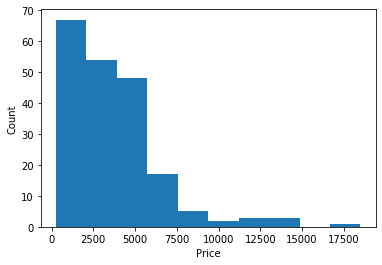

In [25]:
%matplotlib inline
import lxml.html
from matplotlib import pyplot as plt



def parse_name_node(node):
    return node.text


def parse_price_node(node):
    s = node.text
    x = int( s[1:].replace(',', '') )
    return x


def parse_page(fnameHTML):
    tree         = lxml.html.parse(fnameHTML)
    body         = tree.find('body') 
    box          = body.find_class('itemCatBox')[0]
    name_nodes   = box.find_class('name')
    price_nodes  = box.find_class('itemCatPrice')
    names,prices = zip( *[[parse_name_node( n ), parse_price_node( p )]  for n,p in zip(name_nodes, price_nodes)] )
    return list(names), list(prices)


def parse_all(dirname):
    names  = []
    prices = []
    for i in range(5):
        fnameHTML = os.path.join(dirname, f'page{i+1}.html')
        n,p       = parse_page(fnameHTML)
        names    += n
        prices   += p
    return names,prices


def write_results(fnameCSV, names, prices):
    with open(fnameCSV, 'w') as fid:     # open in write mode
        writer = csv.writer(fid)         # create a writer object
        labels = ['Num','Name','Price']  # column labels
        writer.writerow( labels )        # write column labels
        for i,(n,p) in enumerate(zip(names,prices)):   # cycle through rows
            writer.writerow( [i+1,n,p] ) # write the current row to file




# Parse all data:
dir0         = os.path.abspath('')                        # directory in which this notebook is saved
dirDATA      = os.path.join(dir0, 'kakaku-com')           # directory to parse
names,prices = parse_all(dirDATA)

# Write the results:
fnameCSV     = os.path.join( dir0, 'kakaku-prices.csv' )  # results file name
write_results(fnameCSV, names, prices)

# Plot the distribution of prices
plt.figure()
plt.hist(prices)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


___
<a name="summary"></a>
# Summary
[Back to Table of Contents](#toc)

* Useful Python functions for writing data are:

    * `np.savetxt`
    *  `csv.writer`
    * `open`

* This notebook has demonstrated how to **parse** a relatively complex real-workd HTML structure, and how to extract desired data.